In [12]:
import pickle
with open('/kaggle/input/pre-processamentoc/x_final_completo.pkl', 'rb') as f:
    X = pickle.load(f)
    
with open('/kaggle/input/pre-processamentoc/y_orig_mod.pkl', 'rb') as f:
    Y = pickle.load(f)

In [13]:
import numpy as np
#Y = Y.astype(np.float32)

In [14]:
'''import cv2
import numpy as np
from tensorflow.image import resize

# Supondo que X seja uma lista de imagens coloridas.
X_resized = np.array([resize(image, [100, 100]) for image in X])
#imagens_cinza = np.array([cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2GRAY) for image in X_resized])

def converter_para_rgb(imagens_cinza):
    imagens_rgb = np.stack((imagens_cinza,) * 3, axis=-1)
    return imagens_rgb

imagens_rgba = converter_para_rgb(imagens_cinza)



imagens_rgba[0].shape
#X = preprocess_input(imagens_rgba)

X = X_resized
X.shape


# Convertendo a lista em um array NumPy
X = np.array(X)'''

"import cv2\nimport numpy as np\nfrom tensorflow.image import resize\n\n# Supondo que X seja uma lista de imagens coloridas.\nX_resized = np.array([resize(image, [100, 100]) for image in X])\n#imagens_cinza = np.array([cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2GRAY) for image in X_resized])\n\ndef converter_para_rgb(imagens_cinza):\n    imagens_rgb = np.stack((imagens_cinza,) * 3, axis=-1)\n    return imagens_rgb\n\nimagens_rgba = converter_para_rgb(imagens_cinza)\n\n\n\nimagens_rgba[0].shape\n#X = preprocess_input(imagens_rgba)\n\nX = X_resized\nX.shape\n\n\n# Convertendo a lista em um array NumPy\nX = np.array(X)"

In [15]:
print(np.min(X))
print(np.max(X))
X.shape

0
255


(9947, 100, 100, 3)

In [16]:
from keras.applications.resnet50 import preprocess_input 
X = preprocess_input(X)

2024-07-23 18:25:54.174858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 18:25:54.174975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 18:25:54.304168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
print(np.min(X))
print(np.max(X))
X.shape

-123.68
151.061


(9947, 100, 100, 3)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [19]:
import numpy as np

unique, counts = np.unique(Y_train, return_counts=True)
ocorrencias = dict(zip(unique, counts))
print("Distribuição no conjunto de treino")
print(ocorrencias)

unique, counts = np.unique(Y_test, return_counts=True)
ocorrencias = dict(zip(unique, counts))

print("Distribuição no conjunto de teste")
print(ocorrencias)

Distribuição no conjunto de treino
{0: 6304, 1: 1653}
Distribuição no conjunto de teste
{0: 1562, 1: 428}


In [20]:
'''import os
import cv2
import albumentations as A
from skimage.io import imread, imsave
from pathlib import Path

# transformações
import albumentations as A

transformacoes = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=1),
    A.HorizontalFlip(p=0.5),
])



novas = 10

index = 0
labels = []
x_train = []

for arquivo in X_train:
    imagem = arquivo
    holder = Y_train[index]
    index += 1
    for i in range(novas):
        imagem_transformada = transformacoes(image=imagem)['image']
        labels.append(holder)
        x_train.append(imagem_transformada)
        
import numpy as np


X_train = np.array(x_train)  
Y_train = np.array(labels)  
'''
import numpy as np
import albumentations as A

# Transformações
transformacoes = A.Compose([
    A.Rotate(limit=20),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0),
    A.HorizontalFlip(),
    A.RandomScale(scale_limit=0.1),
    A.Resize(width=100, height=100, p=1),  # Garante que todas as imagens tenham o mesmo tamanho
])

novas = 4
labels = []
x_train = []

for index, imagem in enumerate(X_train):
    holder = Y_train[index]
    
    # Redimensionar a imagem original para garantir uniformidade
    imagem_resized = transformacoes(image=imagem)['image']
    
    if Y_train[index] == 0:
        labels.append(holder)
        x_train.append(imagem_resized)
    else:
        for i in range(novas):
            imagem_transformada = transformacoes(image=imagem)['image']
            labels.append(holder)
            x_train.append(imagem_transformada)

# Convertendo as listas para arrays NumPy
X_train = np.stack(x_train)  # Usa np.stack para garantir que as imagens sejam empilhadas corretamente
Y_train = np.array(labels)  # Convertendo para NumPy array


In [21]:
import numpy as np

unique, counts = np.unique(Y_train, return_counts=True)
ocorrencias = dict(zip(unique, counts))
print("Distribuição no conjunto de treino")
print(ocorrencias)

unique, counts = np.unique(Y_test, return_counts=True)
ocorrencias = dict(zip(unique, counts))

print("Distribuição no conjunto de teste")
print(ocorrencias)

Distribuição no conjunto de treino
{0: 6304, 1: 6612}
Distribuição no conjunto de teste
{0: 1562, 1: 428}


In [22]:
# Criando o objeto StratifiedKFold para 3 folds
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Dicionário para armazenar os dados de treino de cada fold
folds = {}

# Dividindo os dados em folds
for i, (train_index, _) in enumerate(kfold.split(X_train, Y_train)):
    folds[f'x_train_{i+1}'] = X_train[train_index]
    folds[f'y_train_{i+1}'] = Y_train[train_index]

# Agora você tem x_train_1, y_train_1, x_train_2, y_train_2, x_train_3, y_train_3 armazenados no dicionário `folds`
x_train_1, y_train_1 = folds['x_train_1'], folds['y_train_1']
x_train_2, y_train_2 = folds['x_train_2'], folds['y_train_2']
x_train_3, y_train_3 = folds['x_train_3'], folds['y_train_3']

In [23]:
import numpy as np

unique, counts = np.unique(y_train_1, return_counts=True)
ocorrencias = dict(zip(unique, counts))
print("Distribuição no FOLD 1")
print(ocorrencias)

unique, counts = np.unique(y_train_2, return_counts=True)
ocorrencias = dict(zip(unique, counts))

print("Distribuição no FOLD 2")
print(ocorrencias)

unique, counts = np.unique(y_train_3, return_counts=True)
ocorrencias = dict(zip(unique, counts))

print("Distribuição no FOLD 3")
print(ocorrencias)

Distribuição no FOLD 1
{0: 4202, 1: 4408}
Distribuição no FOLD 2
{0: 4203, 1: 4408}
Distribuição no FOLD 3
{0: 4203, 1: 4408}


In [24]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

def create_resnet50():
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)
        model = Model(inputs=base_model.input, outputs=predictions)

        for layer in base_model.layers:
            layer.trainable = False
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        return model


In [25]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.regularizers import l2

scores = []
tempo = []
historys = []
metricas_por_fold = []
melhor_model = None
melhor_f1_score = 0

if(True):
    start_time = time.time()
    tf.keras.backend.clear_session()
    
    n_splits = 3
    hist = []
    holder = []
    metricas_fold = []
    
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    
    i = 0
    for train_idx, val_idx in kfold.split(X_train, Y_train):
        tf.keras.backend.clear_session()
        early_stopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='min', restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-5)
        modelo = create_resnet50()
        X_train_fold, Y_train_fold = X_train[train_idx], Y_train[train_idx]
        X_val_fold, Y_val_fold = X_train[val_idx], Y_train[val_idx]
        
        history = modelo.fit(X_train_fold, Y_train_fold, epochs=30, validation_data=(X_val_fold, Y_val_fold), callbacks=[early_stopping, reduce_lr])
        holder.append(modelo.evaluate(X_val_fold, Y_val_fold, verbose=0))

        # Previsão e cálculo das métricas para o conjunto de validação
        previsoes_val = modelo.predict(X_val_fold)
        previsoes_binarias_val = [1 if x > 0.5 else 0 for x in previsoes_val]

        # Relatório de Classificação para o conjunto de validação
        relatorio_dict = classification_report(Y_val_fold, previsoes_binarias_val, target_names=["Classe 0", "Classe 1"], output_dict=True)
        precision_val = relatorio_dict['macro avg']['precision']
        recall_val = relatorio_dict['macro avg']['recall']
        f1_val = relatorio_dict['macro avg']['f1-score']
        
        # Calcular AUC-ROC
        auc_roc_val = roc_auc_score(Y_val_fold, previsoes_val)
        
        print("Relatório de Classificação (Validação):\n", classification_report(Y_val_fold, previsoes_binarias_val, target_names=["Classe 0", "Classe 1"]))
        print(f"F1: {f1_val:.4f}, Recall: {recall_val:.4f}, Precision: {precision_val:.4f}, AUC-ROC: {auc_roc_val:.4f}")
        metricas_fold.append((f1_val, recall_val, precision_val, auc_roc_val))
        
        # Verificar se este é o melhor modelo com base no F1-score
        if f1_val > melhor_f1_score:
            melhor_f1_score = f1_val
            melhor_model = modelo 
            bf = i
        i += 1
        del modelo

    # Guardar histórico e métricas
    hist.append(history)
    historys.append(hist)
    metricas_por_fold.append(metricas_fold)
    
    end_time = time.time()
    tempo.append(end_time - start_time)
    scores.append(holder)

# Exibir as métricas por fold e por fase
print(metricas_por_fold)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
  7/270 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4995 - loss: 13.9871  

I0000 00:00:1721759202.464767     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


270/270 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - accuracy: 0.6946 - loss: 9.3271 - val_accuracy: 0.7724 - val_loss: 2.8689 - learning_rate: 0.0010
Epoch 2/30
  7/270 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7253 - loss: 2.9079

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7528 - loss: 2.3698 - val_accuracy: 0.7359 - val_loss: 1.3255 - learning_rate: 0.0010
Epoch 3/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7649 - loss: 1.1752 - val_accuracy: 0.7608 - val_loss: 0.8686 - learning_rate: 0.0010
Epoch 4/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7719 - loss: 0.8163 - val_accuracy: 0.7452 - val_loss: 0.8156 - learning_rate: 0.0010
Epoch 5/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7648 - loss: 0.7152 - val_accuracy: 0.7764 - val_loss: 0.6570 - learning_rate: 0.0010
Epoch 6/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7718 - loss: 0.6672 - val_accuracy: 0.6853 - val_loss: 0.9207 - learning_rate: 0.0010
Epoch 7/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7594 - loss: 0.7459 - val_accuracy: 0.7501 - val_loss: 0.7012 - learning_rate: 0.0010
Epoch 8/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7627 - loss: 0.7015 - val_

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7516 - loss: 2.3642 - val_accuracy: 0.7751 - val_loss: 1.2283 - learning_rate: 0.0010
Epoch 3/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7524 - loss: 1.1309 - val_accuracy: 0.7777 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 4/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7583 - loss: 0.9186 - val_accuracy: 0.7812 - val_loss: 0.7105 - learning_rate: 0.0010
Epoch 5/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7607 - loss: 0.7095 - val_accuracy: 0.7691 - val_loss: 0.6816 - learning_rate: 0.0010
Epoch 6/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7566 - loss: 0.6922 - val_accuracy: 0.7691 - val_loss: 0.6753 - learning_rate: 0.0010
Epoch 7/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7628 - loss: 0.6945 - val_accuracy: 0.7840 - val_loss: 0.6178 - learning_rate: 0.0010
Epoch 8/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7639 - loss: 0.6424 - val_

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7503 - loss: 2.1107 - val_accuracy: 0.7533 - val_loss: 1.1533 - learning_rate: 0.0010
Epoch 3/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7675 - loss: 1.0557 - val_accuracy: 0.7738 - val_loss: 0.7747 - learning_rate: 0.0010
Epoch 4/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7678 - loss: 0.7510 - val_accuracy: 0.7494 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 5/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7658 - loss: 0.6724 - val_accuracy: 0.7449 - val_loss: 0.6606 - learning_rate: 0.0010
Epoch 6/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7631 - loss: 0.6619 - val_accuracy: 0.7661 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 7/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7829 - loss: 0.6258 - val_accuracy: 0.7584 - val_loss: 0.6341 - learning_rate: 0.0010
Epoch 8/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7647 - loss: 0.6249 - val_

In [26]:
model = melhor_model

In [27]:
Y_test = np.array(Y_test)

Forma de X_test: (1990, 100, 100, 3)
Forma de Y_test: (1990,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step
Forma das previsões: (1990, 1)
Acurácia no conjunto de teste: 0.6748743718592964
Matriz de Confusão:
 [[960 602]
 [ 45 383]]


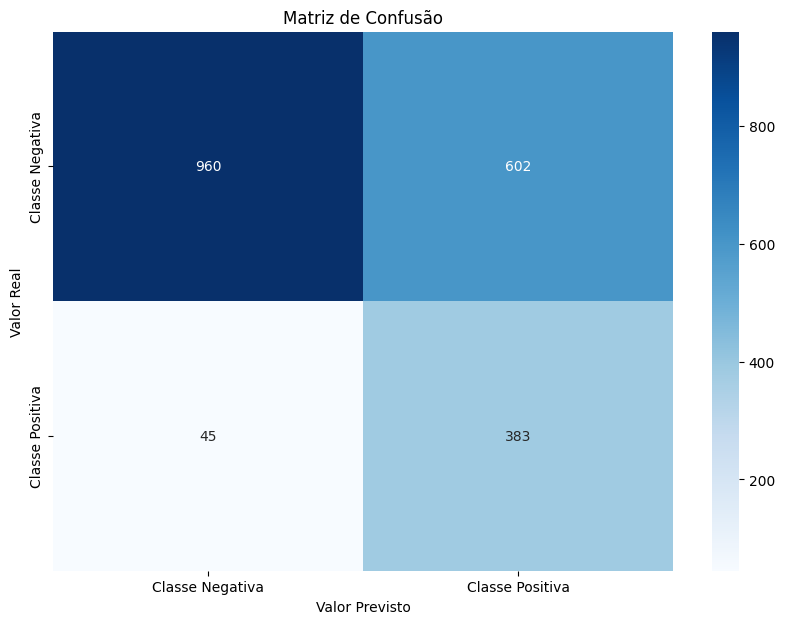

Relatório de Classificação:
               precision    recall  f1-score   support

    Classe 0       0.96      0.61      0.75      1562
    Classe 1       0.39      0.89      0.54       428

    accuracy                           0.67      1990
   macro avg       0.67      0.75      0.65      1990
weighted avg       0.83      0.67      0.70      1990



In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Certifique-se de que X_test e Y_test tenham a forma correta
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de Y_test: {Y_test.shape}")

# Verifique se X_test não está vazio
if X_test.size == 0:
    raise ValueError("X_test está vazio")

# Realize a predição
previsoes = model.predict(X_test)

# Verifique a forma das previsões
print(f"Forma das previsões: {previsoes.shape}")

# Converta as previsões para binário
previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

# Avaliação da acurácia
acuracia = accuracy_score(Y_test, previsoes_binarias)
print(f"Acurácia no conjunto de teste: {acuracia}")

# Matriz de Confusão
matriz_confusao = confusion_matrix(Y_test, previsoes_binarias)
print("Matriz de Confusão:\n", matriz_confusao)

# Plot da Matriz de Confusão
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

# Relatório de Classificação
relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"])
print("Relatório de Classificação:\n", relatorio_classificacao)


In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def train_model(model, X_train, Y_train, EPOCHS=30):
    # Usando 'val_accuracy' em vez de 'val_acc'
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10,verbose=1,
                               mode='max', restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5,
                                  verbose=1, mode='max', min_lr=1e-5)

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size=16,
                        epochs=EPOCHS,
                        callbacks=[reduce_lr, early_stop])
    return history


In [30]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

def create_resnet50_L():
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)
        model = Model(inputs=base_model.input, outputs=predictions)

        for layer in base_model.layers:
            layer.trainable = True
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        return model


melor fold = 2
OIBOMDIA 0
Epoch 1/30
431/431 ━━━━━━━━━━━━━━━━━━━━ 47s 64ms/step - accuracy: 0.6947 - loss: 8.9212 - val_accuracy: 0.7545 - val_loss: 2.5739 - learning_rate: 0.0010
Epoch 2/30
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7451 - loss: 2.0599 - val_accuracy: 0.7330 - val_loss: 1.0845 - learning_rate: 0.0010
Epoch 3/30
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7501 - loss: 0.9788 - val_accuracy: 0.6947 - val_loss: 0.8048 - learning_rate: 0.0010
Epoch 4/30
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7536 - loss: 0.7487 - val_accuracy: 0.7481 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 5/30
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7596 - loss: 0.6846 - val_accuracy: 0.7208 - val_loss: 0.7095 - learning_rate: 0.0010
Epoch 6/30
429/431 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7513 - loss: 0.6809
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - 

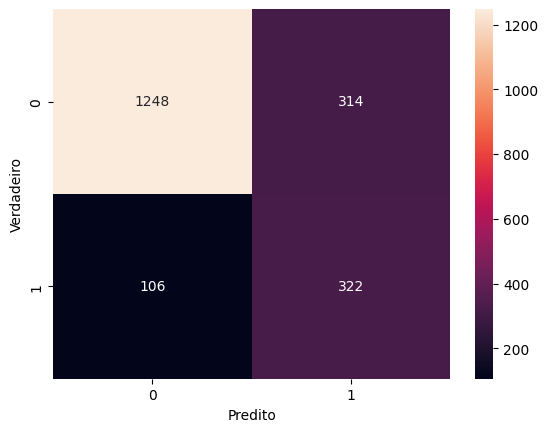

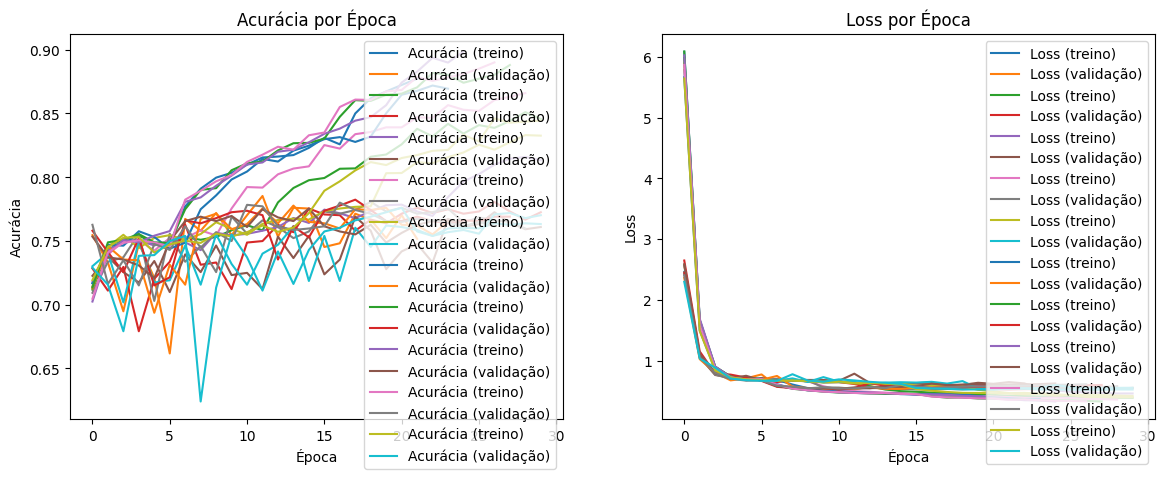

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Importe a biblioteca NumPy

# Listas para armazenar as métricas de cada iteração
accuracies = []
precisions = []
recalls = []
f1_scores = []
historys = []
if(bf==0):
    treinox = x_train_1
    treinoy = y_train_1
    print("melor fold = 1")
elif(bf==1):
    treinox = x_train_2
    treinoy = y_train_2
    print("melor fold = 2")
else:
    treinox = x_train_3
    treinoy = y_train_3
    print("melor fold = 3")

for i in range(10):
    print("OIBOMDIA",i)
    tf.keras.backend.clear_session()
    model = create_resnet50()
    historys.append(train_model(model, treinox, treinoy, 30))

    previsoes = model.predict(X_test)
    previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

    # Adiciona a acurácia à lista
    acuracia = accuracy_score(Y_test, previsoes_binarias)
    accuracies.append(acuracia)

    # Calcula e adiciona precisão, recall e f1-score à suas respectivas listas
    relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"], output_dict=True)
    # Capturando os valores individuais de precisão, recall e F1-score para a classe '1'
    precisao_classe_1 = relatorio_classificacao['macro avg']['precision']
    recall_classe_1 = relatorio_classificacao['macro avg']['recall']
    f1_score_classe_1 = relatorio_classificacao['macro avg']['f1-score']

    print(f"Precisão : {precisao_classe_1}")
    print(f"Recall : {recall_classe_1}")
    print(f"F1-Score : {f1_score_classe_1}")

    precisions.append(precisao_classe_1)
    recalls.append(recall_classe_1)
    f1_scores.append(f1_score_classe_1)


# Calcula a média de cada métrica
acuracia_media = np.mean(accuracies)
precisao_media = np.mean(precisions)
recall_medio = np.mean(recalls)
f1_score_medio = np.mean(f1_scores)

# Calcula o desvio padrão de cada métrica
acuracia_dp = np.std(accuracies)
precisao_dp = np.std(precisions)
recall_dp = np.std(recalls)
f1_score_dp = np.std(f1_scores)

# Exibe os resultados
print(f"Acurácia média: {acuracia_media} ± {acuracia_dp}")
print(f"Precisão média: {precisao_media} ± {precisao_dp}")
print(f"Recall médio: {recall_medio} ± {recall_dp}")
print(f"F1-Score médio: {f1_score_medio} ± {f1_score_dp}")

# Opção para plotar a matriz de confusão da última iteração
cm = confusion_matrix(Y_test, previsoes_binarias)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

import matplotlib.pyplot as plt

# Configuração do gráfico de Acurácia
plt.figure(figsize=(14, 5))

# Gráfico de Acurácia por Época para cada history
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
for history in historys:
    plt.plot(history.history['accuracy'], label='Acurácia (treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Configuração do gráfico de Loss
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
for history in historys:
    plt.plot(history.history['loss'], label='Loss (treino)')
    plt.plot(history.history['val_loss'], label='Loss (validação)')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [32]:
#model.save_weights('/kaggle/working/VGG-16.weights.h5')